In [2]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
dview = rc[:]  # A DirectView of all engines
dview.block = True
rc.ids

[0, 1, 2, 3, 4]

In [3]:
%%px
import bluefog.torch as bf
from bluefog.common import topology_util
import networkx as nx

bf.init()
message = f"Hello, I am {bf.rank()} among {bf.size()} processes"
print(message)

[stdout:4] Hello, I am 1 among 5 processes


[stdout:1] Hello, I am 2 among 5 processes


[stdout:2] Hello, I am 4 among 5 processes


[stderr:4] Invalid MIT-MAGIC-COOKIE-1 key

[stdout:3] Hello, I am 3 among 5 processes


[stdout:0] Hello, I am 0 among 5 processes


[stderr:2] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:3] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:0] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:1] Invalid MIT-MAGIC-COOKIE-1 key

In [4]:
# import os
# import sys
# import numpy as np

# from pymanopt.optimizers import ConjugateGradient

# sys.path.append('/home/yl-02/下载/experiments-main')

# from core.offline_problem import OfflineProblem
# from lib.function import pca
# from solver.offline_solver import OfflineSolver

# import config
# n=config.n
# T=config.T
# #block=config.block
# foldname = config.foldname
# St = config.mfd
# A = np.load( foldname + 'data_wave.npy' )
# X_0 = config.X_0

# list_T= list(np.arange(config.T))


# off_prob = OfflineProblem(  mfd = St,
#                             data = A,
#                             time = T,
#                             sum_loss = pca.sum_f,
#                             sum_grad = pca.sum_grad 
#                         ) 

# solver = OfflineSolver(solver = ConjugateGradient, mingrad = 1e-3)

# #X_0 = solver.optimize(off_prob,X_0,[T-1])
# X_opt = solver.optimize(off_prob,X_0,list_T)


# np.save( foldname +'data_offline',solver.offline_histories)
# #np.save( foldname + 'list_T',list_T)
# print('offline solver completed')
# opt = pca.func( A, X_opt)
# print(opt)

# dview.push({"X_opt": X_opt})
#dview.push({"opt": opt})

In [5]:
import os
import sys
import numpy as np
from sklearn.decomposition import PCA

import config
foldname = config.foldname

sys.path.append('/home/yl-02/下载/experiments-main')
from lib.function import pca

A = np.load( foldname + 'data_wave.npy' )

model = PCA(n_components = 5)
lower_dim_data = model.fit_transform(A)
print(f"降维后的特征维数：{model.n_components_}")

X_opt = model.components_.T
opt = pca.sum_f( A, X_opt)
print(opt)
print(X_opt)
dview.push({"X_opt": X_opt})
dview.push({"opt": opt})

np.save( foldname + 'X_0',X_opt)

/home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
降维后的特征维数：5
-7.209687433619089
[[ 5.23416204e-03  8.90591632e-03  7.95193084e-02 -2.18253597e-01
  -1.96997208e-02]
 [-1.02336508e-01 -1.15669641e-01  9.93195480e-03  1.12822763e-01
  -2.63466743e-02]
 [-1.79023368e-01 -1.86024247e-01  6.15270738e-02 -3.44157254e-02
  -2.79768422e-02]
 [-2.26534205e-01 -2.12657749e-01  1.95475141e-02 -5.33808192e-03
  -5.41032817e-03]
 [-2.54594016e-01 -2.29799408e-01 -1.33625814e-02  3.60177562e-03
   2.30918880e-02]
 [-2.83124098e-01 -1.54194548e-01 -1.20665492e-02 -1.54393002e-03
   1.14168441e-02]
 [-3.04900199e-01 -8.94719466e-02  1.18327995e-02  1.79494747e-02
   8.23275382e-03]
 [-2.96762738e-01  4.43405869e-02 -1.68079244e-02 -1.13231861e-02
   6.71385070e-03]
 [-2.49267598e-01  2.35992195e-01 -1.67001675e-02  3.48696834e-03
  -1.85694939e-03]
 [-1.33860086e-01  3.92769410e-01 -2.17925896e-02  3.30972730e-03
   2.83478603e-03]
 [ 8.40376482e-03  4.66391588e-01 -3.14984634e-03 -4.8

In [6]:
#数据分配
#import torch.utils.data.distributed


samples= A.shape[0]
num_nodes = len(rc.ids)
num_split = int(samples // num_nodes)
for i in range(num_nodes):
    data = A[i * num_split : (i + 1) * num_split]
    dview.push({"data": data}, targets=i)

In [7]:
%%px
import os
import sys

sys.path.append('/home/yl-02/下载/experiments-main')
import numpy as np
from core.online_problem import OnlineProblem
from lib.function import pca
from solver.stochastic_GTA import *

sys.path.append('/home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform')
import config


n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.ExponentialTwoGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver = StochasticGTA()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

[stdout:1] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:2] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:3] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:0] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


[stdout:4] /home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform/data/
gradient solver completed


In [8]:
sys.path.append('/home/yl-02/下载/experiments-main')
from solver.stochastic_GTA import *

solver = StochasticGTA()
hat_SGTA = dview.pull("solver.X_hat", block=True, targets=0)
grad_SGTA = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGTA = dview.pull("solver.oracle", block=True, targets=0)
value_SGTA = []
for i in range(len(hat_SGTA)):
    loss = pca.sum_f(A, hat_SGTA[i])
    value_SGTA.append(loss)

np.save( foldname + 'value_SGTA',value_SGTA)
np.save( foldname + 'grad_SGTA',grad_SGTA)
np.save( foldname+ 'oracle_SGTA',oracle_SGTA)

In [9]:
%%px
from solver.DR_SGD import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0

#graph
node = bf.size()    #number of nodes
G = topology_util.ExponentialTwoGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver =DR_SGD()
solver.optimize(ol_problem,X_0, X_opt)

print('gradient solver completed')

[stdout:3] gradient solver completed


[stdout:2] gradient solver completed


[stdout:1] gradient solver completed


[stdout:4] gradient solver completed


[stdout:0] gradient solver completed


In [10]:
from solver.DR_SGD import *

solver = DR_SGD()
hat_SGD= dview.pull("solver.X_hat", block=True, targets=0)
grad_SGD = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGD = dview.pull("solver.oracle", block=True, targets=0)
value_SGD = []
for i in range(len(hat_SGTA)):
    loss = pca.sum_f(A, hat_SGD[i])
    value_SGD.append(loss)
    
np.save( foldname + 'value_SGD',value_SGD)
np.save( foldname + 'grad_SGD',grad_SGD)
np.save( foldname+ 'oracle_SGD',oracle_SGD)

In [11]:
%%px
from solver.cons_sample import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.ExponentialTwoGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = config.eta,
                                loss = pca.func,
                                grad = pca.grad,
                                ) 

solver = ConsSample()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

[stdout:2] gradient solver completed


[stdout:1] gradient solver completed


[stdout:0] gradient solver completed


[stdout:4] gradient solver completed


[stdout:3] gradient solver completed


In [12]:
from solver.cons_sample import *

solver = ConsSample()
hat_cons = dview.pull("solver.X_hat", block=True, targets=0)
grad_cons = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_cons = dview.pull("solver.oracle", block=True, targets=0)
value_cons = []
for i in range(len(hat_SGTA)):
    loss = pca.sum_f(A, hat_cons[i])
    value_cons.append(loss)

np.save( foldname + 'value_cons',value_cons)
np.save( foldname + 'grad_cons',grad_cons)
np.save( foldname+ 'oracle_cons',oracle_cons)

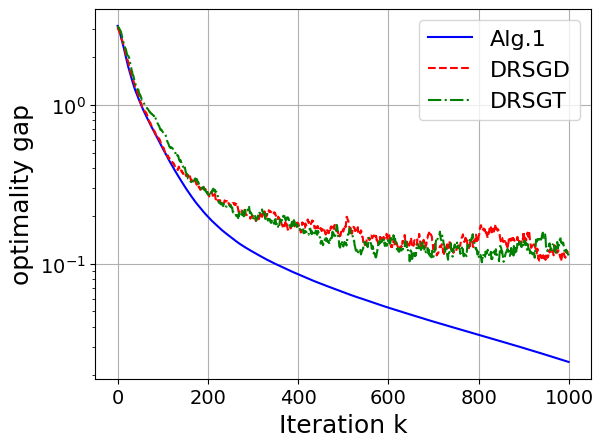

In [13]:
#plot
import sys
sys.path.append('.')

from lib.operation.calculate_gap import cal_gap
from lib.operation.figureplot import *
import matplotlib.pyplot as plt
import numpy as np
import config

foldname = config.foldname
res= load_data(foldname)
grid = list(np.arange(config.T))

cal_gap(res, opt)
plot_value (res,grid)
plt.show()

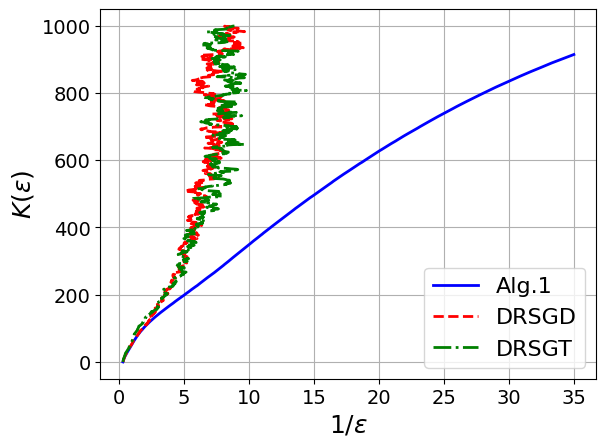

<Figure size 640x480 with 0 Axes>

In [14]:
for alg in res.values():
    axis_x = [x for x in alg['epsilon'] if x <= 35]
    length = len(axis_x)
    y = grid[:length]
    plt.plot(axis_x,y,linewidth=2,**alg["plot"])   

plt.legend(prop={'size':16})
plt.xlabel('$1/\epsilon$',fontdict={'size':18})
plt.ylabel('$K(\epsilon)$',fontdict={'size':18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.gcf().set_facecolor(np.ones(3))
plt.grid(True)
plt.show()

plt.savefig( 'ite_complex.png')

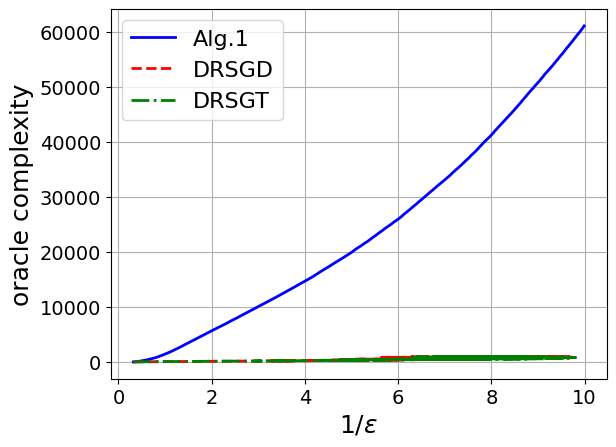

<Figure size 640x480 with 0 Axes>

In [15]:
for alg in res.values():
    axis_x = [x for x in alg['epsilon'] if x <= 10]
    length = len(axis_x)
    y = alg['oracle'][:length]
    plt.plot(axis_x,y,linewidth=2,**alg["plot"]) 

plt.legend(prop={'size':16})
plt.xlabel('$1/\epsilon$',fontdict={'size':18})
plt.ylabel('oracle complexity',fontdict={'size':18})
plt.xticks(size=14)
plt.yticks(size=14)
plt.gcf().set_facecolor(np.ones(3))
plt.grid(True)
plt.show()

plt.savefig( 'orc_complex.png')